In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from collections import Counter

# Load graph from pickle file (loaded as a dictionary)
with open('gnn_input.pkl', 'rb') as f:
    graph_dict = pickle.load(f)

# Create a NetworkX graph
graph = nx.Graph()


Number of nodes: 254667
Number of edges: 181086


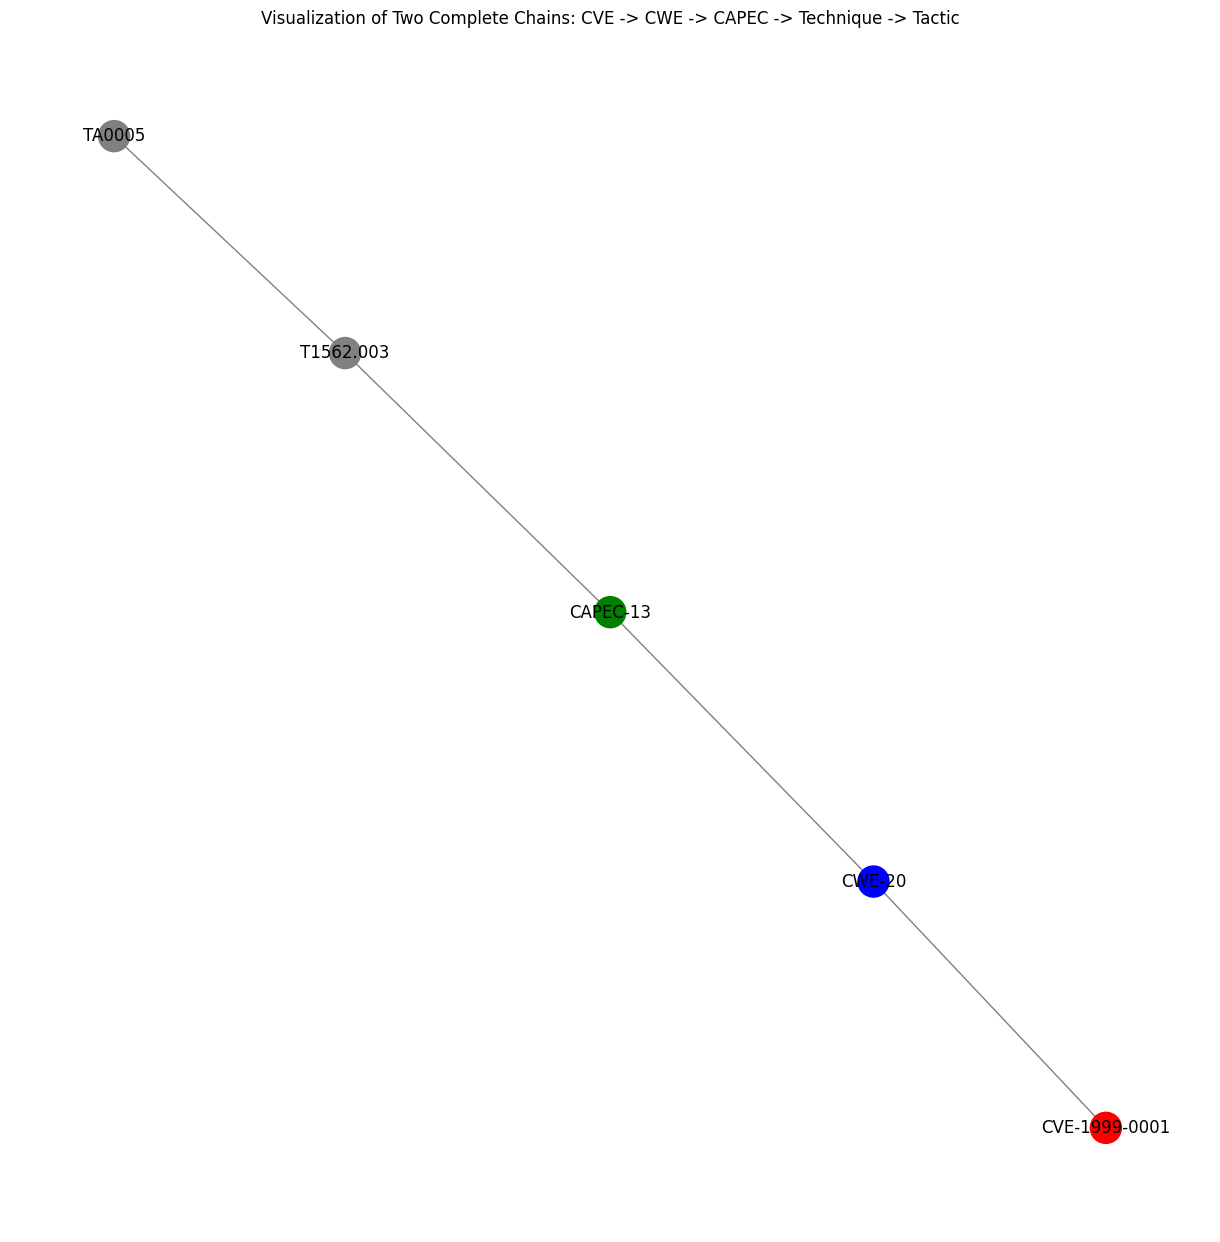

In [3]:
# Add nodes to the graph
for node in graph_dict["nodes"]:
    graph.add_node(node['id'], type=node['type'], description_embedding=node['features'].get('description_embedding'))

# Add edges to the graph
for edge in graph_dict["edges"]:
    graph.add_edge(edge['source'], edge['target'], relationship=edge['relationship'])

# Print number of nodes and edges
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

# Attempting to visualize only two complete chains of CVE -> CWE -> CAPEC -> Technique -> Tactic
# Find two complete chains
complete_chains = []
for edge in graph_dict["edges"]:
    if edge['relationship'] == 'cve_to_cwe':
        cve_node = edge['source']
        cwe_node = edge['target']
        if not graph.has_node(cwe_node):
            continue
        for next_edge in graph_dict["edges"]:
            if next_edge['source'] == cwe_node and next_edge['relationship'] == 'cwe_to_capec':
                capec_node = next_edge['target']
                if not graph.has_node(capec_node):
                    continue
                for next_edge_2 in graph_dict["edges"]:
                    if next_edge_2['source'] == capec_node and next_edge_2['relationship'] == 'capec_to_technique':
                        technique_node = next_edge_2['target']
                        if not graph.has_node(technique_node):
                            continue
                        for next_edge_3 in graph_dict["edges"]:
                            if next_edge_3['source'] == technique_node and next_edge_3['relationship'] == 'technique_to_tactic':
                                tactic_node = next_edge_3['target']
                                if not graph.has_node(tactic_node):
                                    continue
                                complete_chains.append([cve_node, cwe_node, capec_node, technique_node, tactic_node])
                                if len(complete_chains) == 1:
                                    break
                    if len(complete_chains) == 1:
                        break
            if len(complete_chains) == 1:
                break
    if len(complete_chains) == 1:
        break

# Check if complete chains were found
if not complete_chains:
    print("No complete chains found. Please check the data for missing links.")
else:
    # Extract nodes and edges for the complete chains
    selected_nodes = set()
    selected_edges = []
    for chain in complete_chains:
        for i in range(len(chain) - 1):
            selected_nodes.add(chain[i])
            selected_nodes.add(chain[i + 1])
            selected_edges.append((chain[i], chain[i + 1]))

    # Create the subgraph with the selected nodes and edges
    subgraph = nx.Graph()
    subgraph.add_nodes_from((node, graph.nodes[node]) for node in selected_nodes)
    subgraph.add_edges_from(selected_edges)

    # Define colors for different node types
    color_map = []
    for node in subgraph.nodes(data=True):
        node_type = node[1].get('type', 'Unknown')
        if node_type == 'CVE':
            color_map.append('red')
        elif node_type == 'CWE':
            color_map.append('blue')
        elif node_type == 'CAPEC':
            color_map.append('green')
        elif node_type == 'Technique':
            color_map.append('orange')
        elif node_type == 'Tactic':
            color_map.append('purple')
        else:
            color_map.append('grey')

    # Draw the subgraph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(subgraph)  # Layout for positioning the nodes
    nx.draw(subgraph, pos, with_labels=True, node_size=500, edge_color='grey', node_color=color_map)
    plt.title("Visualization of Two Complete Chains: CVE -> CWE -> CAPEC -> Technique -> Tactic")
    plt.show()


Number of nodes: 254667
Number of edges: 181086
Checking CVE -> CWE: CVE-1999-0001 -> CWE-20
Checking CWE -> CAPEC: CWE-20 -> CAPEC-10
Checking CWE -> CAPEC: CWE-20 -> CAPEC-101
Checking CWE -> CAPEC: CWE-20 -> CAPEC-104
Checking CWE -> CAPEC: CWE-20 -> CAPEC-108
Checking CWE -> CAPEC: CWE-20 -> CAPEC-109
Checking CWE -> CAPEC: CWE-20 -> CAPEC-110
Checking CWE -> CAPEC: CWE-20 -> CAPEC-120
Checking CWE -> CAPEC: CWE-20 -> CAPEC-13
Checking CAPEC -> Technique: CAPEC-13 -> T1562.003
Checking Technique -> Tactic: T1562.003 -> TA0005
Checking CAPEC -> Technique: CAPEC-13 -> T1574.006
Checking Technique -> Tactic: T1574.006 -> TA0003
Checking Technique -> Tactic: T1574.006 -> TA0004
Checking Technique -> Tactic: T1574.006 -> TA0005
Checking CAPEC -> Technique: CAPEC-13 -> T1574.007
Checking Technique -> Tactic: T1574.007 -> TA0003
Checking Technique -> Tactic: T1574.007 -> TA0004
Checking Technique -> Tactic: T1574.007 -> TA0005
Checking CWE -> CAPEC: CWE-20 -> CAPEC-135
Checking CWE -> CAP

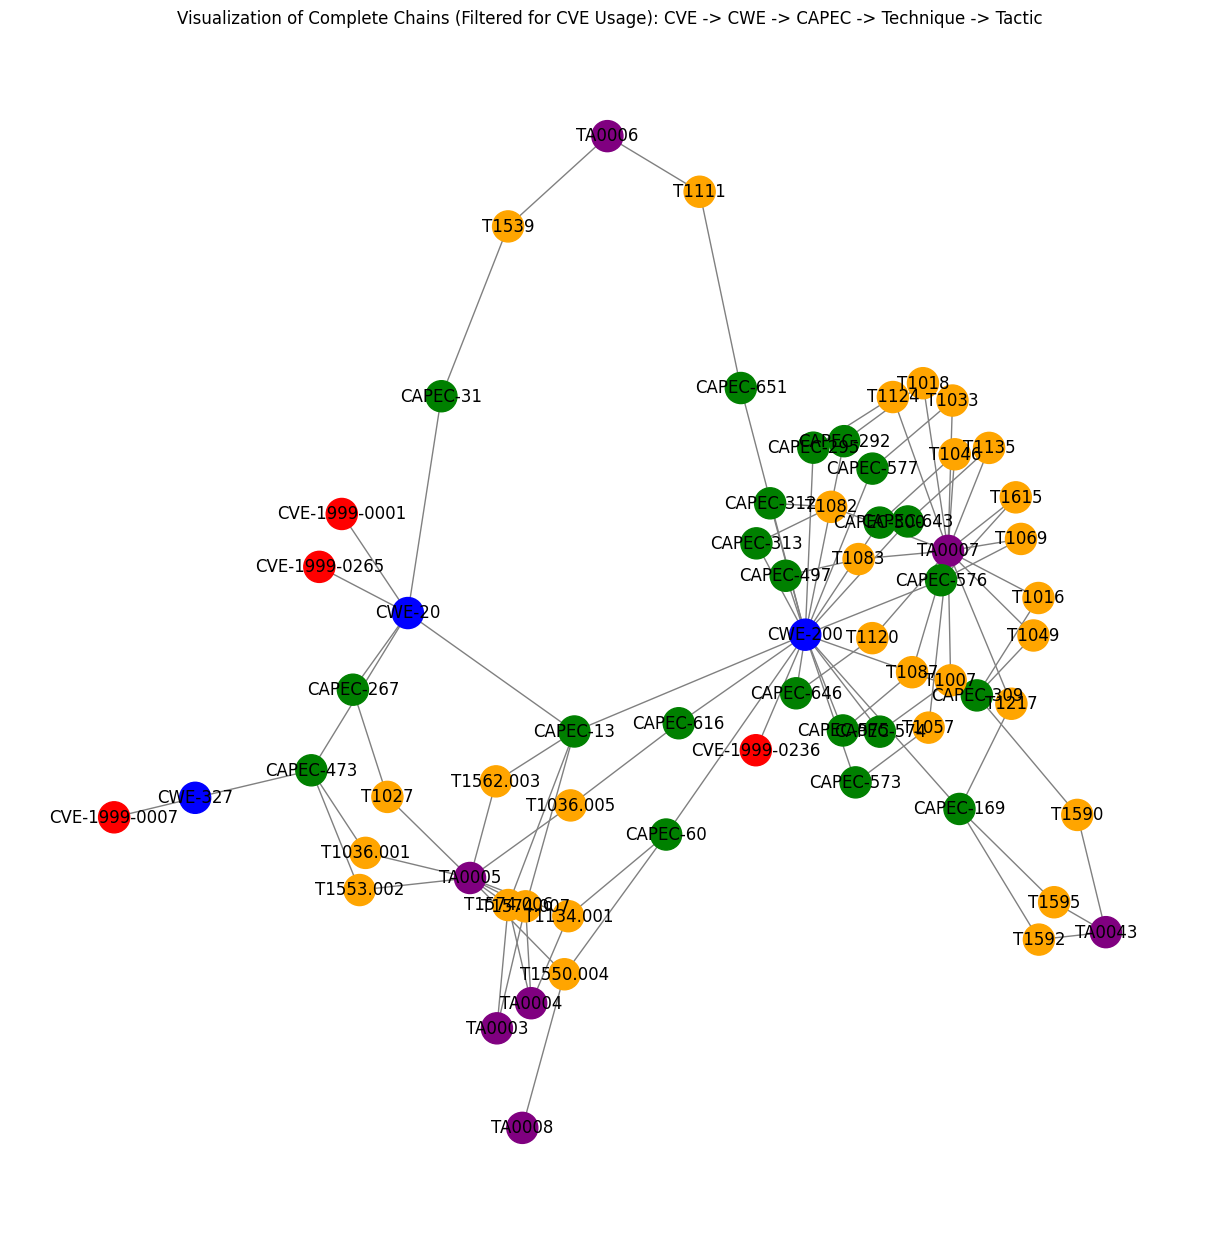

In [4]:

# Add nodes to the graph
for node in graph_dict["nodes"]:
    graph.add_node(node['id'], type=node['type'], description_embedding=node['features'].get('description_embedding'))

# Add edges to the graph
for edge in graph_dict["edges"]:
    graph.add_edge(edge['source'], edge['target'], relationship=edge['relationship'])

# Print number of nodes and edges
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

# Find up to 1000 complete chains
complete_chains = []
used_cves = set()  # To track used CVEs

for edge in graph_dict["edges"]:
    if edge['relationship'] == 'cve_to_cwe':
        cve_node = edge['source']
        cwe_node = edge['target']

        print(f"Checking CVE -> CWE: {cve_node} -> {cwe_node}")
        if not graph.has_node(cwe_node):
            print(f"CWE node {cwe_node} does not exist in the graph.")
            continue

        for next_edge in graph_dict["edges"]:
            if next_edge['source'] == cwe_node and next_edge['relationship'] == 'cwe_to_capec':
                capec_node = next_edge['target']
                print(f"Checking CWE -> CAPEC: {cwe_node} -> {capec_node}")
                if not graph.has_node(capec_node):
                    print(f"CAPEC node {capec_node} does not exist in the graph.")
                    continue

                for next_edge_2 in graph_dict["edges"]:
                    if next_edge_2['source'] == capec_node and next_edge_2['relationship'] == 'capec_to_technique':
                        technique_node = next_edge_2['target']
                        print(f"Checking CAPEC -> Technique: {capec_node} -> {technique_node}")
                        if not graph.has_node(technique_node):
                            print(f"Technique node {technique_node} does not exist in the graph.")
                            continue

                        for next_edge_3 in graph_dict["edges"]:
                            if next_edge_3['source'] == technique_node and next_edge_3['relationship'] == 'technique_to_tactic':
                                tactic_node = next_edge_3['target']
                                print(f"Checking Technique -> Tactic: {technique_node} -> {tactic_node}")
                                if not graph.has_node(tactic_node):
                                    print(f"Tactic node {tactic_node} does not exist in the graph.")
                                    continue

                                # Add the chain
                                complete_chains.append([cve_node, cwe_node, capec_node, technique_node, tactic_node])
                                if len(complete_chains) == 50:
                                    break
                    if len(complete_chains) == 50:
                        break
            if len(complete_chains) == 50:
                break
    if len(complete_chains) == 50:
        break

# Filter out chains where a CVE appears more than twice
filtered_chains = []
for chain in complete_chains:
    cve_counts = Counter(node for node in chain if graph.nodes[node].get('type') == 'CVE')
    if all(count <= 2 for count in cve_counts.values()):
        filtered_chains.append(chain)

# Replace complete_chains with filtered_chains
complete_chains = filtered_chains

# Check if complete chains were found
if not complete_chains:
    print("No complete chains found. Please check the data for missing links or duplicate CVEs.")
else:
    # Extract nodes and edges for the complete chains
    selected_nodes = set()
    selected_edges = []
    for chain in complete_chains:
        for i in range(len(chain) - 1):
            selected_nodes.add(chain[i])
            selected_nodes.add(chain[i + 1])
            selected_edges.append((chain[i], chain[i + 1]))

    # Print the complete chains found
    for chain in complete_chains:
        print(f"Complete chain found: {chain}")

    # Create the subgraph with the selected nodes and edges
    subgraph = nx.Graph()
    subgraph.add_nodes_from((node, graph.nodes[node]) for node in selected_nodes)
    subgraph.add_edges_from(selected_edges)

    # Define colors for different node types
    color_map = []
    for node in subgraph.nodes(data=True):
        node_type = node[1].get('type', 'Unknown')
        if node_type == 'CVE':
            color_map.append('red')
        elif node_type == 'CWE':
            color_map.append('blue')
        elif node_type == 'CAPEC':
            color_map.append('green')
        elif node_type == 'TECHNIQUE':
            color_map.append('orange')
        elif node_type == 'TACTIC':
            color_map.append('purple')
        else:
            color_map.append('grey')

    # Plot the subgraph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(subgraph)  # Layout for positioning the nodes
    nx.draw(subgraph, pos, with_labels=True, node_size=500, edge_color='grey', node_color=color_map)
    plt.title("Visualization of Complete Chains (Filtered for CVE Usage): CVE -> CWE -> CAPEC -> Technique -> Tactic")
    plt.show()


Number of nodes: 254667
Number of edges: 181086
Checking CVE -> CWE: CVE-2023-0001 -> CWE-319
Checking CWE -> CAPEC: CWE-319 -> CAPEC-102
Checking CWE -> CAPEC: CWE-319 -> CAPEC-117
Checking CWE -> CAPEC: CWE-319 -> CAPEC-383
Checking CAPEC -> Technique: CAPEC-383 -> T1056.004
Checking Technique -> Tactic: T1056.004 -> TA0009
Checking Technique -> Tactic: T1056.004 -> TA0006
Checking CWE -> CAPEC: CWE-319 -> CAPEC-477
Checking CWE -> CAPEC: CWE-319 -> CAPEC-65
Checking CAPEC -> Technique: CAPEC-65 -> T1040
Checking Technique -> Tactic: T1040 -> TA0006
Checking Technique -> Tactic: T1040 -> TA0007
Checking CVE -> CWE: CVE-2023-0003 -> CWE-610
Checking CWE -> CAPEC: CWE-610 -> CAPEC-219
Checking CVE -> CWE: CVE-2023-0005 -> CWE-312
Checking CWE -> CAPEC: CWE-312 -> CAPEC-37
Checking CAPEC -> Technique: CAPEC-37 -> T1005
Checking Technique -> Tactic: T1005 -> TA0009
Checking CAPEC -> Technique: CAPEC-37 -> T1552.004
Checking Technique -> Tactic: T1552.004 -> TA0006
Checking CVE -> CWE: CV

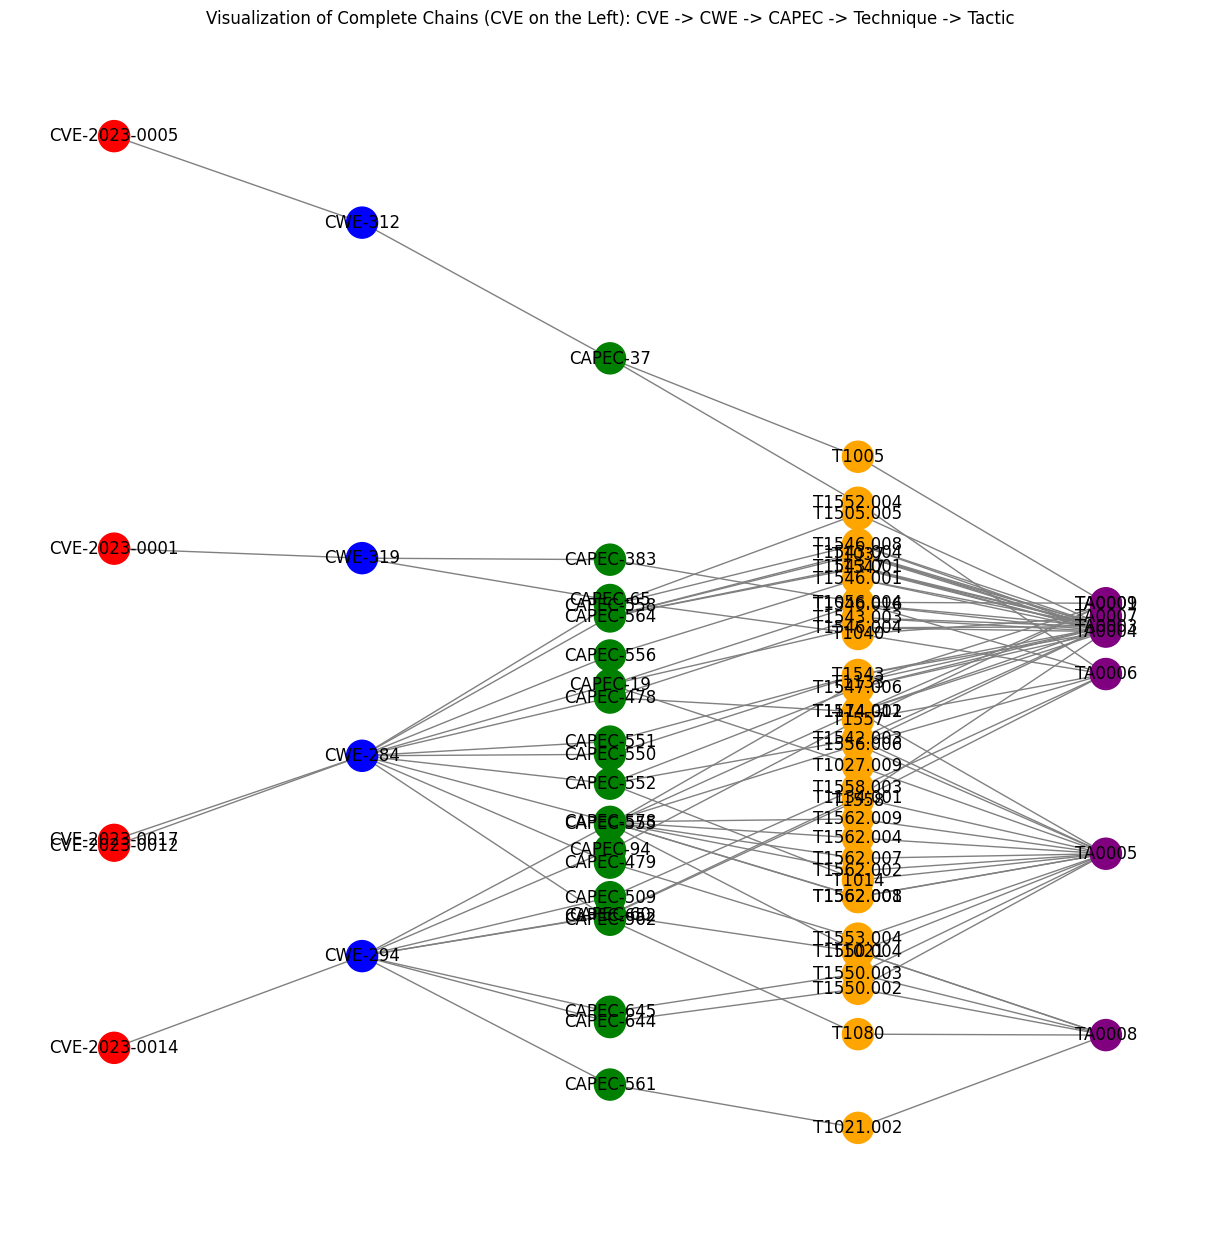

In [5]:
for node in graph_dict["nodes"]:
    graph.add_node(node['id'], type=node['type'], description_embedding=node['features'].get('description_embedding'))

# Add edges to the graph
for edge in graph_dict["edges"]:
    graph.add_edge(edge['source'], edge['target'], relationship=edge['relationship'])

# Print number of nodes and edges
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

# Find up to 1000 complete chains using only CVE nodes with ID CVE-2023
complete_chains = []

for edge in graph_dict["edges"]:
    if edge['relationship'] == 'cve_to_cwe':
        cve_node = edge['source']
        cwe_node = edge['target']

        # Skip if this CVE node does not start with "CVE-2023"
        if not cve_node.startswith("CVE-2023"):
            continue

        print(f"Checking CVE -> CWE: {cve_node} -> {cwe_node}")
        if not graph.has_node(cwe_node):
            print(f"CWE node {cwe_node} does not exist in the graph.")
            continue

        for next_edge in graph_dict["edges"]:
            if next_edge['source'] == cwe_node and next_edge['relationship'] == 'cwe_to_capec':
                capec_node = next_edge['target']
                print(f"Checking CWE -> CAPEC: {cwe_node} -> {capec_node}")
                if not graph.has_node(capec_node):
                    print(f"CAPEC node {capec_node} does not exist in the graph.")
                    continue

                for next_edge_2 in graph_dict["edges"]:
                    if next_edge_2['source'] == capec_node and next_edge_2['relationship'] == 'capec_to_technique':
                        technique_node = next_edge_2['target']
                        print(f"Checking CAPEC -> Technique: {capec_node} -> {technique_node}")
                        if not graph.has_node(technique_node):
                            print(f"Technique node {technique_node} does not exist in the graph.")
                            continue

                        for next_edge_3 in graph_dict["edges"]:
                            if next_edge_3['source'] == technique_node and next_edge_3['relationship'] == 'technique_to_tactic':
                                tactic_node = next_edge_3['target']
                                print(f"Checking Technique -> Tactic: {technique_node} -> {tactic_node}")
                                if not graph.has_node(tactic_node):
                                    print(f"Tactic node {tactic_node} does not exist in the graph.")
                                    continue

                                # Add the chain
                                complete_chains.append([cve_node, cwe_node, capec_node, technique_node, tactic_node])
                                if len(complete_chains) == 100:
                                    break
                    if len(complete_chains) == 100:
                        break
            if len(complete_chains) == 100:
                break
    if len(complete_chains) == 100:
        break

# Filter out chains where a CVE appears more than twice
filtered_chains = []
for chain in complete_chains:
    cve_counts = Counter(node for node in chain if graph.nodes[node].get('type') == 'CVE')
    if all(count <= 2 for count in cve_counts.values()):
        filtered_chains.append(chain)

# Replace complete_chains with filtered_chains
complete_chains = filtered_chains

# Check if complete chains were found
if not complete_chains:
    print("No complete chains found. Please check the data for missing links or duplicate CVEs.")
else:
    # Extract nodes and edges for the complete chains
    selected_nodes = set()
    selected_edges = []
    for chain in complete_chains:
        for i in range(len(chain) - 1):
            selected_nodes.add(chain[i])
            selected_nodes.add(chain[i + 1])
            selected_edges.append((chain[i], chain[i + 1]))

    # Create the subgraph with the selected nodes and edges
    subgraph = nx.Graph()
    subgraph.add_nodes_from((node, graph.nodes[node]) for node in selected_nodes)
    subgraph.add_edges_from(selected_edges)

    # Define colors for different node types
    color_map = []
    for node in subgraph.nodes(data=True):
        node_type = node[1].get('type', 'Unknown')
        if node_type == 'CVE':
            color_map.append('red')
        elif node_type == 'CWE':
            color_map.append('blue')
        elif node_type == 'CAPEC':
            color_map.append('green')
        elif node_type == 'TECHNIQUE':
            color_map.append('orange')
        elif node_type == 'TACTIC':
            color_map.append('purple')
        else:
            color_map.append('grey')

    # Define a custom layout with CVE nodes on the left
    pos = nx.spring_layout(subgraph)  # Start with a spring layout
    for node, attributes in subgraph.nodes(data=True):
        pos[node] = (0.5, pos[node][1]) 
        if attributes.get('type') == 'CVE':
            pos[node] = (-1.0, pos[node][1])  # Place CVE nodes on the left
        if attributes.get('type') == 'CWE':
            pos[node] = (-0.5, pos[node][1])
        if attributes.get('type') == 'CAPEC':
            pos[node] = (0, pos[node][1])
        if attributes.get('type') == 'TECNIQUE':
            pos[node] = (1, pos[node][1])
        if attributes.get('type') == 'TACTIC':
            pos[node] = (1.0, pos[node][1])
    # Plot the subgraph
    plt.figure(figsize=(12, 12))
    nx.draw(subgraph, pos, with_labels=True, node_size=500, edge_color='grey', node_color=color_map)
    plt.title("Visualization of Complete Chains (CVE on the Left): CVE -> CWE -> CAPEC -> Technique -> Tactic")
    plt.show()